# Prototype for analytical model classes

The aim of this worksheet is to experiment and design a set of classes for expressing analytical models for well test interpretation. The general idea is that there should be a parent generic class and a set of derived classes allowing to avoid repeating code.

In this first prototype, I consider only the generic parent class and two daughter classes.

Nov. 7 2019 - P. Renard
Nov. 20 2019 - N. Dutler (noflow, laplace)


In [1]:
import sys
sys.path.append("..")
import openhytest as ht

import numpy as np
from scipy.special import expn as E1
import scipy.special as scispe
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
import mpmath as mp
#import math

In [2]:
# Read a data set to test ideas
df = pd.read_csv('../data/ths_ds1.txt',header=None,sep=" ",names=['t','s'])
df2 = pd.read_csv('../data/thn_ds1.txt',header=None,sep=" ",names=['t','s'])


Below is the part where the classes are defined in order to test the concept.

The first thing is to define a generic class AnalyticalModels of analytical models that should contain all the generic functionalities.  Then, we derive two examples of daughter classes: the theis and theis_noflow models. 

The theis_noflow model is wrong (wrong equations and parametrizations and needs to be corrected), but the principle seems to work.

The next steps would be to implement:
- the fit function
- one or a pair of examples with laplace domain solution


In [24]:
# Utilities

def get_logline(df):   
    logt = np.log10( df.t ).values
    Gt = np.array( [logt, np.ones(logt.shape)] )
    p = np.linalg.inv( Gt.dot(Gt.T) ).dot(Gt).dot(df.s) 
    p[1] = 10**( -p[1]/p[0] )
    return p
  
# Parent generic class

class AnalyticalModels():
    def __init__(self,Q=None,r=None):
        self.Q = Q
        self.r = r
    
    def _dimensionless_time(self,p,t):
        return (t/(0.5628*p[1])) * 0.25
    
    def _dimensional_drawdown(self,p,sd):
        return (sd*p[0]*2)/2.302585092994046
 
    def _dimensionless(self,td, option='Stehfest'): #default deHoog
        #mp.dps = 15
        #s = []
        #myLaplace = mp.calculus.inverselaplace.Stehfest(mp)
        #for i in range(0,len(td)):
        #    t = mp.convert(mp.mpf(td[i]))
        #    myLaplace.calc_laplace_parameter(t)
        #    fpvec = [lambda p: 1/p*mp.besselk(0, mp.sqrt(p)) for p in myLaplace.p]
        #    s.append(myLaplace.calc_time_domain_solution(fpvec,t,manual_prec=False))
        G = map( lambda x: mp.invertlaplace(self.dimensionless_laplace, x, method = 'dehoog', dps = 10, degree = 12), td)
        return G
    
    

    def __call__(self,t):
        print("Warning - undefined")
        return None
    
    def T(self,p):
        return 0.1832339 * self.Q / p[0]
    
    def S(self,p):
        return 2.2458394*self.T(p)*p[1]/self.r**2  
    
    def trial(self, p, df): #loglog included: derivatives are missing at the moment.
        figt = plt.figure()
        ax1 = figt.add_subplot(211)
        ax2 = figt.add_subplot(212)
        ax1.loglog(df.t, self.__call__(p,df.t), df.t, df.s,'o' )
        ax1.set_ylabel('s')
        ax1.grid()
        ax1.minorticks_on()
        ax1.grid(which='major', linestyle='--', linewidth='0.5', color='black')
        ax1.grid(which='minor', linestyle=':', linewidth='0.5', color='grey')
        ax2.semilogx(df.t, self.__call__(p,df.t), df.t, df.s,'o' )
        ax2.set_ylabel('s')
        ax2.set_xlabel('t')
        ax2.grid()
        ax2.minorticks_on()
        ax2.grid(which='major', linestyle='--', linewidth='0.5', color='black')
        ax2.grid(which='minor', linestyle=':', linewidth='0.5', color='grey')
        plt.show()
        print( 'T = ', self.T(p) ,'m2/s')
        print( 'S = ', self.S(p) ,'-')
        print( 'Ri = ',self.RadiusOfInfluence(p,df.t),'m' )
        
        
    def fit(self, p,  df, option='lm', output='all'):   
        t = df.t
        s = df.s
        # costfunction
        def fun(p, t, s):
            return np.array(s) - self.__call__(p,t)

        if option == 'lm':
            # Levenberg-Marquard -- Default
            res_p = least_squares(fun, p, args=(t,s), method='lm', xtol=1e-10, verbose=1)      
        elif option == 'trf':
            # Trust Region Reflective algorithm
            res_p = least_squares(fun, p, jac='3-point', args=(t,s), method='trf', verbose=1)
        else: 
            raise Exception('Specify your option')

        if output == 'all': #-- Default
            #define regular points to plot the calculated drawdown
            tc = np.logspace(np.log10(t[0]), np.log10(t[len(t)-1]),  num = len(t), endpoint = True, base = 10.0, dtype = np.float64)
            sc = self.__call__(res_p.x,tc)
            mr = np.mean(res_p.fun)
            sr = 2 * np.nanstd(res_p.fun)
            rms = np.sqrt(np.mean(res_p.fun**2))
            return res_p.x, tc, sc, mr, sr, rms
        elif output == 'p':
            return res_p.x
        elif output  == 'Detailled':
            tc = np.logspace(np.log10(t[0]), np.log10(t[len(t)-1]),  num = len(t), endpoint = True, base = 10.0, dtype = np.float64)
            sc = self.__call__(res_p.x,tc)
            mr = np.mean(res_p.fun)
            sr = 2 * np.nanstd(res_p.fun)
            rms = np.sqrt(np.mean(res_p.fun**2))
            return res_p, tc, sc, mr, sr, rms
        else:
            raise Exception('The output needs to specified: p or all')    
            
# Derived daughter classes

class theis(AnalyticalModels):
    
    def dimensionless(self, td):
        return 0.5*E1(1,0.25/td)
    
    def dimensionless_laplace(self, pd):
        return 1/pd*mp.besselk(0, mp.sqrt(pd))
      
    def dimensionless_logderivative(self, td):
        return 0.5*np.exp(-0.25/td)
    
    def __call__(self, p, t):
        td = self._dimensionless_time(p, t)
        sd = self.dimensionless( td )
        s = self._dimensional_drawdown(p, sd)
        return s
    
    def guess_params(self, df):
        n = len(df)/3
        return get_logline(df[df.index>n])
    
    def RadiusOfInfluence(self,p,t):
        return 2*np.sqrt( self.T(p) * t[len(t)-1] / self.S(p) ) 
    
    def plot_typecurve(self):
        td = np.logspace(-1, 4)
        sd = self.dimensionless(td)
        dd = self.dimensionless_logderivative(td)

        plt.loglog(td,sd,td,dd,'--')
        plt.xlabel('$t_D$')
        plt.ylabel('$s_D$')
        plt.xlim((1e-1,1e4))
        plt.ylim((1e-2,10))
        plt.grid('True')
        plt.legend(['Theis','Derivative'])
        plt.show()

        
class theis_noflow(AnalyticalModels):
    
    def dimensionless(self, td, rd):
        ths = theis()
        return ths.dimensionless(td) + ths.dimensionless(td/rd**2)
    
    def dimensionless_logderivative(self, td, rd):
        ths = theis()
        return ths.dimensionless_logderivative(td) + ths.dimensionless_logderivative(td/rd**2)
     
    def __call__(self, p, t):
        rd =  np.sqrt(p[2] / p[1])
        td = self._dimensionless_time(p, t)
        sd = self.dimensionless(td, rd) 
        s = self._dimensional_drawdown(p, sd)
        return s
    
    def guess_params(self, df):
        n = len(df)/4
        p_late = get_logline(df[df.index>n])      
        p_early = get_logline(df[df.index<2*n])
        return np.array([p_late[0]/2, p_early[1], p_late[1]**2/p_early[1]])

    def RadiusOfInfluence(self,p,t):
        return np.sqrt(2.2458394* self.T(p) * p[2] / self.S(p) ) 
    
    def plot_typecurve(self, rd=np.array([1.3, 3.3, 10, 33])):
        td = np.logspace(-2, 5)
        ax = plt.gca()
        for i in range(0, len(rd)):
            sd = self.dimensionless(td, rd[i])
            dd = self.dimensionless_logderivative(td, rd[i]) 
            color = next(ax._get_lines.prop_cycler)['color']
            plt.loglog(td, sd, '-', color=color, label = rd[i])
            plt.loglog(td, dd, '-.', color=color)
                       
        plt.xlabel('$t_D / r_D^2$')
        plt.ylabel('$s_D$')
        plt.xlim((1e-2, 1e5))
        plt.ylim((1e-2, 20))
        plt.grid('True')
        plt.legend()
        plt.show()
             

# How to create a type curve

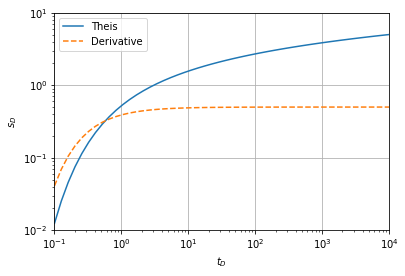

In [25]:
abaque = theis()
abaque.plot_typecurve()


(0.01, 10)

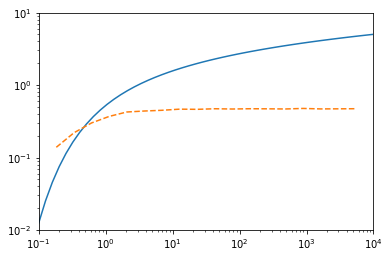

In [42]:
td = np.logspace(-1, 4)
sdn = abaque._dimensionless(td)
sd = list(sdn)
plt.loglog(td, sd)
dev = ht.ldiffs(pd.DataFrame({'td':td, 'sd':sd}))
plt.plot(dev.td,dev.sd, '--')
plt.xlim((1e-1, 1e4))
plt.ylim((1e-2, 10))

In [45]:
sd2 = abaque.dimensionless(td)
residual = sd-sd2

mr = np.mean(residual) #mean resiudal
print(mr)
sr = 2 * np.std(residual) #standard deviation
print(sr)
rms = np.sqrt(np.mean(residual**2))
print(rms)

4.0733031747911e-12
6.55366209792671e-12
5.22775482183447e-12


# How to adjust a Theis model using guess_params and the fit function

estimated parameter vector: [  1.70038569 341.82452507]


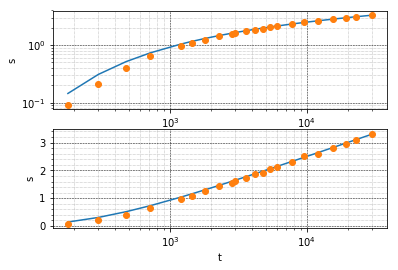

T =  0.0014965736409743885 m2/s
S =  1.838230595036379e-05 -
Ri =  3125.64516579519 m


In [46]:
apaque= theis(Q=1.3888e-2,r=250)
p = apaque.guess_params(df)
print("estimated parameter vector:",p)
apaque.trial(p,df)


In [47]:
p, tc, sc, mr, sr, rms = apaque.fit(p, df, option='trf')

`gtol` termination condition is satisfied.
Function evaluations 5, initial cost 3.2141e-02, final cost 8.4643e-03, first-order optimality 2.15e-10.


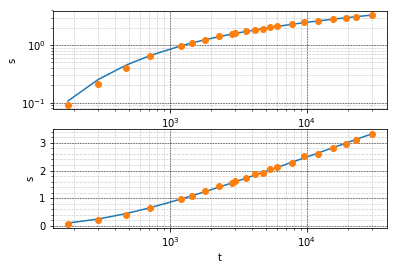

T =  0.00142512353000793 m2/s
S =  2.110457422520216e-05 -
Ri =  2846.6139999696156 m


In [48]:
apaque.trial(p,df)

# Moving to no flow model

/usr/local/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


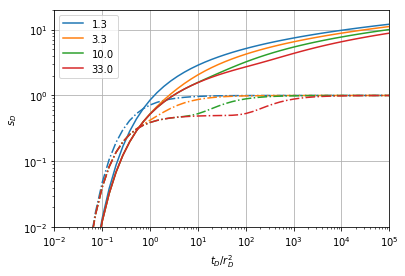

In [49]:
model = theis_noflow()
model.plot_typecurve()

estimated parameter vector: [2.08083534e+00 4.09480142e+02 5.31857688e+04]


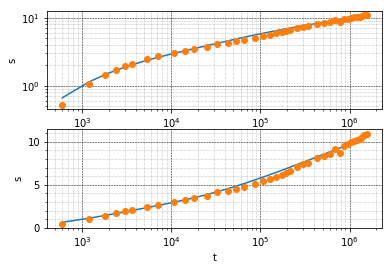

T =  0.0011623637077365074 m2/s
S =  0.0026723515663906582 -
Ri =  227.9351449908511 m


In [50]:
model = theis_noflow(Q=0.0132,r=20)
p = model.guess_params(df2)
print("estimated parameter vector:",p)
model.trial(p,df2)


In [51]:
p, tc, sc, mr, sr, rms = model.fit(p, df2)
p

`ftol` termination condition is satisfied.
Function evaluations 50, initial cost 1.7005e+00, final cost 7.4091e-01, first-order optimality 1.43e-08.


array([2.45693083e+00, 7.00749816e+02, 1.73581927e+05])

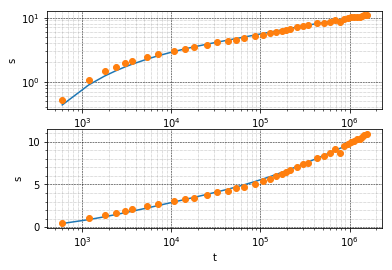

T =  0.000984434504660815 m2/s
S =  0.003873187531444528 -
Ri =  314.77537649835 m


In [52]:
model.trial(p,df2)

In [53]:
#Laplace test
from mpmath import *
myLaplace = calculus.inverselaplace.deHoog(mp)
t = convert(0.25)
myLaplace.calc_laplace_parameter(t)
fp = lambda pd: 1/pd*besselk(0, sqrt(pd))
fpvec = [fp(p) for p in myLaplace.p]
myLaplace.calc_time_domain_solution(fpvec,t,manual_prec=True)

mpf('0.10969196719776013690038')

In [55]:
list(abaque._dimensionless(td))

[mpf('0.012457458935132245539737'),
 mpf('0.025259170072632673373358'),
 mpf('0.045584692180911045265856'),
 mpf('0.074898758379170525881219'),
 mpf('0.11407285390763692405069'),
 mpf('0.16335313440692981676317'),
 mpf('0.22244811436852567412825'),
 mpf('0.29067540327253876125679'),
 mpf('0.36711651588096207848855'),
 mpf('0.45074929706765022585646'),
 mpf('0.54054606636068122660355'),
 mpf('0.63553762748799415283063'),
 mpf('0.7348491100763545197383'),
 mpf('0.8377152260140929979082'),
 mpf('0.94348191095414041251743'),
 mpf('1.0515998499873443483565'),
 mpf('1.1616138147992264295638'),
 mpf('1.2731504021182195041106'),
 mpf('1.3859057527936184117667'),
 mpf('1.4996341260838794984256'),
 mpf('1.6141377426287762120172'),
 mpf('1.7292580259054314284484'),
 mpf('1.8448682093083062505379'),
 mpf('1.9608671919146358764152'),
 mpf('2.0771744904144945897961'),
 mpf('2.1937261274084997042522'),
 mpf('2.3104713044256793841313'),
 mpf('2.4273697235237207681102'),
 mpf('2.5443894394975168360418'